# Stats and Sleep
This notebook contains my final project for STATS 383 (Statistics for ISP) at Northwestern Unviersity. In it, I investigate several questions about my sleep habits using data collected from my Fitbit. 

## 1. Introduction
### Data Sources
The data used in this notebook was collected on my Fitbit Charge HR nightly since July 2015. To access the data, I wrote a Python script to download all of my sleep data from Fitbit, using their API. The script requested each day's worth of data, and stored the API response in log files named as `yyyy-mm-dd.json`. For more information on this, see the script `fitbit.py` and the README in the home directory of my repo `sleep-analysis`.

### Questions of Interest
In this notebook, I will answer the following questions using statistical methods from class:
 * Did how much I sleep change significantly throughout winter?
 * Do I sleep the same amount on each night of the week?
 * To what extent am I affected by sleep debt?
 * Do I take naps uniformly throughout the week?
 
### Setup
Let's setup the notebook by importing useful packages and configuring plots.

In [1]:
%matplotlib inline

from collections import namedtuple
import datetime
import json

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9.0, 6.0]

### Data Format
Before jumping in, let's run some illustrative commands to better understand the shape of the data. One can refer to the [Fitbit documentation](https://dev.fitbit.com/docs/sleep/) for details about the log files' contents. Each day contains two top-level attributes, `sleep` and `summary`:
 * `sleep` is a list of one or more sleep events in a day. Each entry has several attributes, like `isMainSleep` and `minutesAsleep`. In addition, `minuteData.minuteData` contains minute-by-minute sleep data, where each minute has an identifier, 1, 2, or 3, denoting asleep, restless, or awake, respectively.
 * `summary` contains aggregate statistics -- it includes the number of sleep events (`totalSleepRecords`), the total time spent in bed (`totalTimeInBed`), and total time asleep (`TotalMinutesAsleep`).

In [2]:
# This should get the top-level keys 'summary' and 'sleep'
with open('logs/2017-02-01.json') as f:
    sample_data = json.loads(f.read())
    
list(sample_data.keys())

['sleep', 'summary']

In [3]:
# This should get the summary statistics available
list(sample_data['summary'].keys())

['totalMinutesAsleep', 'totalSleepRecords', 'totalTimeInBed']

In [4]:
# This should get the keys for the first sleep entry (isMainSleep, minutesAsleep, etc.)
list(sample_data['sleep'][0].keys())

['startTime',
 'isMainSleep',
 'awakeningsCount',
 'minuteData',
 'restlessCount',
 'minutesToFallAsleep',
 'efficiency',
 'minutesAsleep',
 'awakeCount',
 'logId',
 'awakeDuration',
 'minutesAfterWakeup',
 'restlessDuration',
 'minutesAwake',
 'duration',
 'dateOfSleep',
 'timeInBed']

In [5]:
# This will tell me the number of minutes I spent in bed that night
sample_data['summary']['totalTimeInBed']

215

Note that the sleep record for a particular day contains data from the previous night, not the following night. That is, the data in `2017-02-01.json` will tell me how much I slept the night after January 31st (clearly, not much -- only three and a half hours).

## 2. Sleeping through Winter
I always feel that I get more and more tired towards the end of the quarter. There could be many reasons for this -- more work piling up, mental exhaustion, or not sleeping as much. Is it actually the case that I sleep less as the quarter goes on? To study this, we'll obtain time-series data of time spent in bed versus day in the quarter, and perform linear regression on it to see if there is a significantly negative slope. Seeing this would indicate that I did indeed sleep less as the quarter went on.

Winter quarter started on January 3rd, and has not yet ended, so we use the date of writing as the last date of analysis. We're interested in the total time spent in bed during winter. But I want to study how much time I spent asleep at night, without considering naps. Because of this, I'll only look at the events where `isMainSleep` is `true`.

In [6]:
# Dates of interest, and NamedTuple to hold data
dates = pd.date_range("2017-01-03", "2017-03-15")
data = []

# Obtain time spent in bed for each main sleep event
for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname, "r") as f:
        date_data = json.loads(f.read())
        
        for sleep_event in date_data["sleep"]:
            if sleep_event["isMainSleep"]:
                data.append(sleep_event["timeInBed"])

# Convert to Pandas dataframe
df = pd.DataFrame(data, columns = ["duration"], index = dates)

Let's clean this a little. Add a column for the number of days since the start of winter (this will make regression much easier), and convert the durations from minutes to hours. We can look at the first few entries to get a feel for the data.

In [7]:
df["date_delta"] = (df.index - dates.min())  / np.timedelta64(1,'D')
df["duration"] /= 60

df.head()

,duration,date_delta
2017-01-03,6.033333,0.0
2017-01-04,6.566667,1.0
2017-01-05,8.016667,2.0
2017-01-06,5.733333,3.0
2017-01-07,10.850000,4.0


We'll plot the data, do a linear regression, and look at the results.

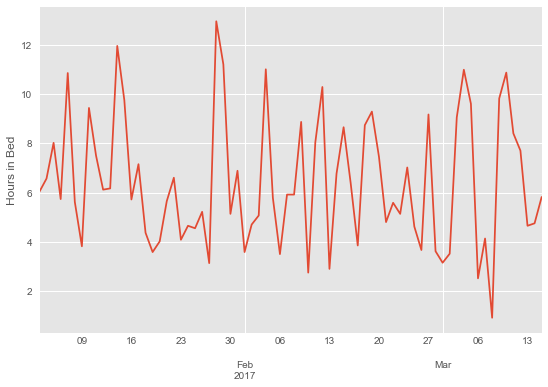

In [8]:
df["duration"].plot()
plt.ylabel("Hours in Bed");

In [9]:
# Create a fitted model for duration vs. date
model = smf.ols(formula = 'duration ~ date_delta', data = df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.6769,0.619,10.783,0.000,5.442,7.912
date_delta,-0.0076,0.015,-0.505,0.615,-0.038,0.022


Qualitatively, we can see from the line graph above that the plot is very noisy, and it's hard to see that any trend exists. Indeed, the confidence interval for the linear coefficient is (-0.038, 0.022), which includes zero; likewise, the p-value is 0.615. We d not conclude there is a significant trend in my sleep duration over the course of the quarter.

We can also graph the regression line against the actual data (as a scatterplot, this time, for readability) to see this.

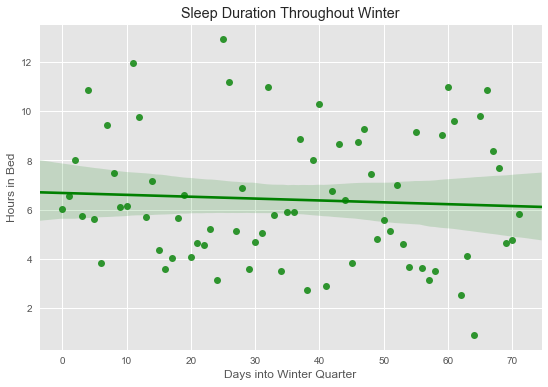

In [10]:
# Plot the durations with the regression line
sns.regplot(x = df.date_delta, y = df.duration, color = "g")
plt.xlabel("Days into Winter Quarter")
plt.ylabel("Hours in Bed")
plt.title("Sleep Duration Throughout Winter");

Indeed, it is clear that we cannot conclude that I slept less as winter quarter went on.

## 3. A Week's Worth of Sleep
Another thought I've had about my sleep habits is that I don't sleep a consistent amount every night. This is partially unsurprising -- for instance, I'm sure I sleep more on weekends than on weekdays. Do I sleep, on average, the same amount each night of the week?

To answer this question, we consider *all* my data, from July 2015 until now. We'll plot the distribution of sleep durations for each day of the week and then run an ANOVA test over these seven categories.

In [11]:
# Dates of interest, and list to hold data
dates = pd.date_range("2015-07-21", "2017-03-15")
data = []

# Obtain data for each main sleep event
for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname, "r") as f:
        date_data = json.loads(f.read())
        
        for sleep_event in date_data["sleep"]:
            if sleep_event["isMainSleep"]:
                data.append(sleep_event["timeInBed"])

# Convert to Pandas dataframe
df = pd.DataFrame(data, columns = ["duration"], index = dates)

Once again, clean up the data by transforming duration into a number of hours. We also add columns for the day of the week, both numerically and by name (`pandas` numbers days as 0 = Monday, ... , 6 = Sunday).

In [12]:
df.duration = df.duration / 60.0

# Add column and labels for day of week
df["day_of_week"] = df.index.weekday
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 
        5: "Saturday", 6: "Sunday"}
df["day_name"] = df["day_of_week"].apply(lambda x: days[x])


df.head()

,duration,day_of_week,day_name
2015-07-21,7.983333,1,Tuesday
2015-07-22,8.600000,2,Wednesday
2015-07-23,5.866667,3,Thursday
2015-07-24,6.516667,4,Friday
2015-07-25,9.183333,5,Saturday


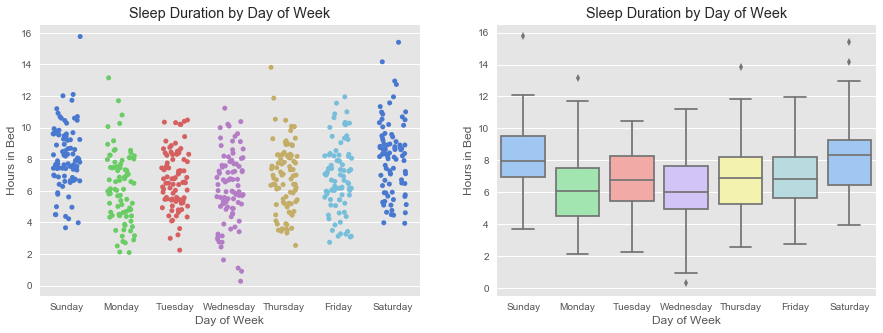

In [13]:
# Create plots
days_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 5))
sns.stripplot(x = df.day_name, y = df.duration, jitter = 0.25, order = days_order, palette = "muted", ax = ax1)
sns.boxplot(x = df.day_name, y = df.duration, order = days_order, palette = "pastel", ax = ax2)

# Label axes
ax1.set_xlabel("Day of Week")
ax1.set_ylabel("Hours in Bed")
ax1.set_title("Sleep Duration by Day of Week") 
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Hours in Bed")
ax2.set_title("Sleep Duration by Day of Week") ;

Qualitatively, it looks like I slept the least on Sunday and Tuesday nights and slept the most on Friday and Saturday nights. (Recall that the entry for a particular day contains sleep data from the previous night, so Monday being low means that I didn't sleep as much on Sunday nights.)

Now, let's run an ANOVA test on this.

In [14]:
model = smf.ols(formula = "duration ~ day_name", data = df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
day_name,361.615437,6.0,13.235257,4.214057e-14
Residual,2718.552184,597.0,NaN,NaN


Because the F-statistic is high and the p-value very low, we can conclude that the mean sleep duration is not the same across days. However, we note that while the ANOVA test assumes that samples are independent, this might not be the case. For instance, sleeping less on one night could mean that I sleep more on the following night. It is unclear how strong this effect is, or if it exists at all; regardless, it is worth considering when drawing conclusions about this data.

## 4. The (Sleep) Debt Crisis
Next, I want to study the question of sleep debt. The idea that one can "catch up on sleep" has [often](https://sleepfoundation.org/sleep-news/you-cant-catch-sleep) been [debated](http://www.scientificamerican.com/article/fact-or-fiction-can-you-catch-up-on-sleep) by scientists. But anecdotal experience from my college career fully supports the idea that if I don't sleep much one night, I will likely be sleeping more the next night.

Let's look into this. I once again consider all my data, and include naps this time (since if I'm taking a nap to catch up on sleep, it make sense to include that). We take the duration of sleep from each night and subtract from it the duration of sleep the night before. This gives a "duration difference" that tells us how much *more* we slept that night than the previous.

In [15]:
# Dates of interest, and list to hold data
dates = pd.date_range("2015-07-21", "2017-03-15")
data = []

# Obtain total time spent in bed for each day
for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname, "r") as f:
        date_data = json.loads(f.read())
        
        data.append(date_data["summary"]["totalTimeInBed"])

# Convert to Pandas dataframe; convert duration to hours
df = pd.DataFrame(data, columns = ["duration"], index = dates)
df.duration /= 60

In [16]:
# Set duration_prev to duration of sleep the day before
df["duration_prev"] = df.shift(1).duration

# Set duration_diff to difference between current night and previous night of sleep
df["duration_diff"] = df.duration - df.duration_prev

df.head()

,duration,duration_prev,duration_diff
2015-07-21,7.983333,NaN,NaN
2015-07-22,8.600000,7.983333,0.616667
2015-07-23,5.866667,8.600000,-2.733333
2015-07-24,12.950000,5.866667,7.083333
2015-07-25,9.183333,12.950000,-3.766667


Next, we can perform regression analysis on this. Let's plot the difference in sleep durations versus how much I slept the night before, and construct a linear model as before.

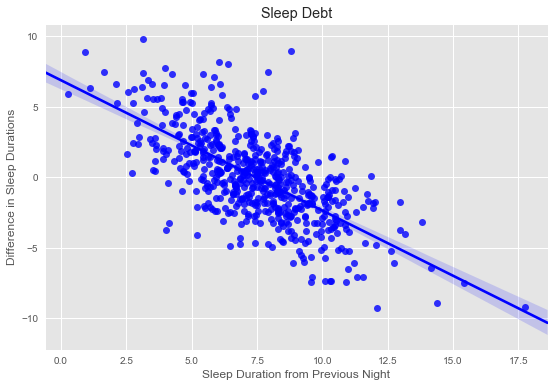

In [17]:
# Plot how much more I slept each night vs. amount slept night before
sns.regplot(x = df.duration_prev, y = df.duration_diff, color = "b")
plt.xlabel("Sleep Duration from Previous Night")
plt.ylabel("Difference in Sleep Durations")
plt.title("Sleep Debt");

In [18]:
model = smf.ols(formula = 'duration_diff ~ duration_prev', data = df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.8633,0.316,21.690,0.000,6.242,7.485
duration_prev,-0.9234,0.041,-22.697,0.000,-1.003,-0.844


In [19]:
model.rsquared

0.4615349482355583

We visually see a strong negative association between these two factors, and our regression analysis tells us that the relationship is significant. Indeed, it seems that on nights when I slept fewer than 6 hours, I was likely to sleep more the next night. Conversely, on nights where I slept more than that, I was likely to sleep less the next night.

## 5. There's a Nap for That
In the last section, I look at the distribution of days I took naps. Were naps uniformly distributed across days? We define a nap as a non-main sleep event that started between the hours of 10am and 10pm. (This time frame is somewhat arbitrary, but should not lead to very many issues.) 

Once again using the entire dataset, we count the number of naps taken on each day of the week. We will then run a chi-squared test of homogeneity to see if the distribution of naps was uniform across days.

In [20]:
# Dates of interest, and list to hold data
dates = pd.date_range("2015-07-21", "2017-03-15")
time_min = pd.to_datetime("10:00:00").time()
time_max = pd.to_datetime("22:00:00").time()
data = []

# Obtain naps: non-main sleep events that started after 10am and before 10pm
for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname, "r") as f:
        date_data = json.loads(f.read())
        
        for sleep_event in date_data["sleep"]:
            if (not sleep_event["isMainSleep"] 
                and pd.to_datetime(sleep_event["startTime"]).time() > time_min
                and pd.to_datetime(sleep_event["startTime"]).time() < time_max):
                dow = pd.to_datetime(sleep_event["startTime"]).dayofweek
                data.append(dow)

# Convert to Pandas dataframe, which is simply a list of dayofweeks where I took naps
df = pd.DataFrame(data, columns = ["day_of_week"])

In [21]:
# Add column and labels for day of week
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 
        5: "Saturday", 6: "Sunday"}
df["day_name"] = df["day_of_week"].apply(lambda x: days[x])

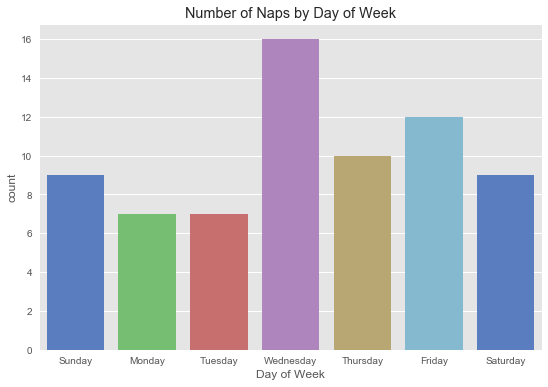

In [22]:
days_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.countplot(x = "day_name", data = df, palette = "muted", order = days_order)
plt.xlabel("Day of Week")
plt.title("Number of Naps by Day of Week");

Let's run a chi-squared test of homogeneity on this. By default, scipy assumes that the categories are equally likely, so we only need to feed it the observed counts.

In [23]:
counts = df.day_name.value_counts()
scipy.stats.chisquare(counts)

Power_divergenceResult(statistic=6.0, pvalue=0.42319008112684359)

We see that the chi-squared statistic is just 6.0; on six degrees of freedom, this is not unusual, and the p-value reflects this. It seems that, despite taking many Wednesday naps, the distribution of naps is not a significant departure from homogeneity.

## 6. Conclusions
### Summary
We summarize the answers to our questions of interest:

**Did how much I sleep change significantly throughout winter?** No; though we found a slight negative trend in how much I slept as the quarter went on, a regression analysis did not find it to be significant. A great deal of variability was observed in sleep durations throughout the quarter.

**Do I sleep the same amount on each night of the week?** No; when considering my sleep durations on each day of the week, an  analysis of variance (ANOVA) found that they were not evenly distributed. It was observed that I slept less on Sunday and Tuesday nights, and more on the weekends.

**To what extent am I affected by sleep debt?** A great deal. We compared the difference in sleep duration (how much I slept one night minus how much I slept the night before) to how much I slept the night before, expecting to see a negative trend. (If I didn't sleep much one night, I would expect to sleep more the following night, according to the sleep debt hypothesis.) Indeed, a significant negative correlation was observed, supporting the existence of sleep debt.

**Do I take naps uniformly throughout the week?** Yes; after performing a chi-squared test of homogeneity, the distribution of naps throughout the week was found to be reasonably homogenous.

### Lessons Learned and Future Directions
Ultimately, this project helped me to gain more insights into my personal sleep habits. It was interesting to see how my experiences and theories about how I sleep were not always supported by reality. For instance, I am still convinced that I get more tired as the quarter goes on, but this does not appear to be because I sleep less. However, my anecdotal experience with sleep debt was supported by my data.

Next steps could include comparing different academic quarters to each other, studying differences throughout my college career. In addition, I could expand my analysis to include other data from my Fitbit, such as heart rate or activity levels, and look for how other aspects of my life are correlated with my sleep habits.